# Better Understanding Langevin Dynamics
Implementing a simple version of generative modeling using Langevin Dynamics with using the precise score function.

Ben Eliav

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
SAMPLES = 100
NUM_STEPS = 10000
LR = 0.01

# Implementation 1: 1D Langevin Dynamics Converging to GMM distribution
1D Gaussian mixture model with 0.5 chance being centered around 2 and 0.5 chance being centered around -2.

In [3]:
def langevin_dynamics(score, x, num_steps=NUM_STEPS, step_size=LR):
    for _ in range(num_steps):
        score_x = score(x)
        x = x + 0.5 * step_size * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
        x += np.sqrt(step_size) * torch.randn_like(x)
    return x

In [4]:
def mixture_of_gaussians(x):
    return torch.log(0.5 * torch.exp(-0.5 * (x - 2).pow(2)) + 0.5 * torch.exp(-0.5 * (x + 2).pow(2)))

In [5]:
sample = torch.rand(1000, requires_grad=True) * 4 - 2
final = langevin_dynamics(mixture_of_gaussians, sample)

In [6]:
def visualize_samples(samples):
    plt.hist(samples.detach().numpy(), bins=100, density=True)
    plt.show()

Prior is a simple uniform distribution between -2 and 2.

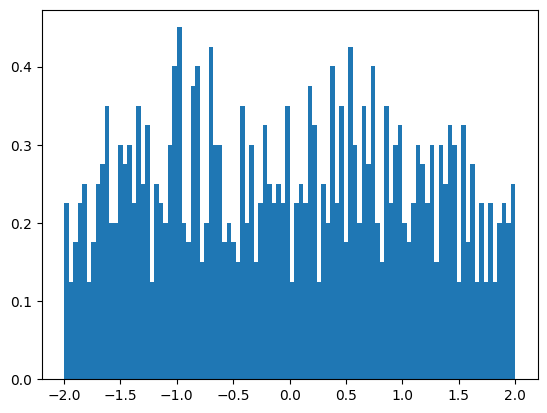

In [7]:
visualize_samples(sample)

The model remarkably recovers the original GMM

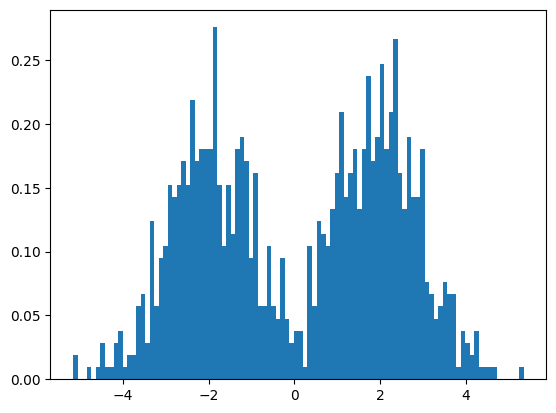

In [8]:
visualize_samples(final)

# Implementation 2: Multivariate Langevin Dynamics
2D multivariate normal, GMM with 0.5 chance of being centered at -1, -1 and 0.5 of being centered at 1, 1

In [9]:
def mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1):
    normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))


In [10]:
sample = torch.randn(1000, 2, requires_grad=True)
mu1, sigma1 = torch.tensor([1., 1.]), 0.1
mu2, sigma2 = torch.tensor([-1., -1.]), 0.1
p1 = 0.5
final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)


In [11]:
def visualize_samples2(samples):
    plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
    plt.show()
    

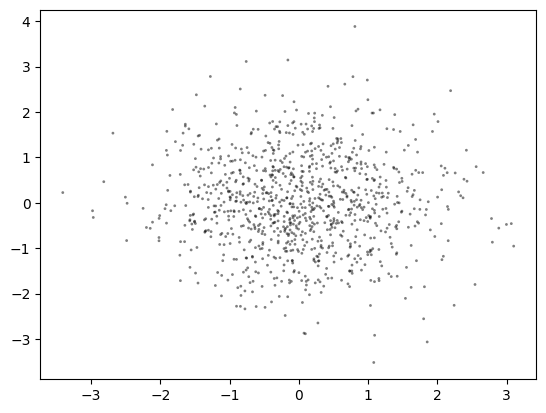

In [12]:
visualize_samples2(sample)

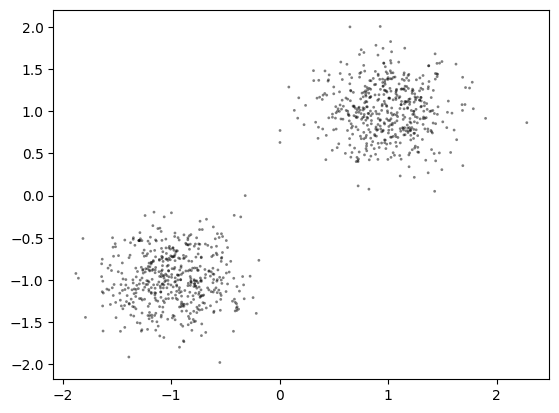

In [13]:
visualize_samples2(final)

# Implementation 3: Imbalanced GMM
What happens when the probability of being in one cluster are higher? This information is supposed to be lost in the process of taking the gradient 

In [14]:
sample = torch.randn(1000, 2, requires_grad=True)
p1 = 0.1

final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

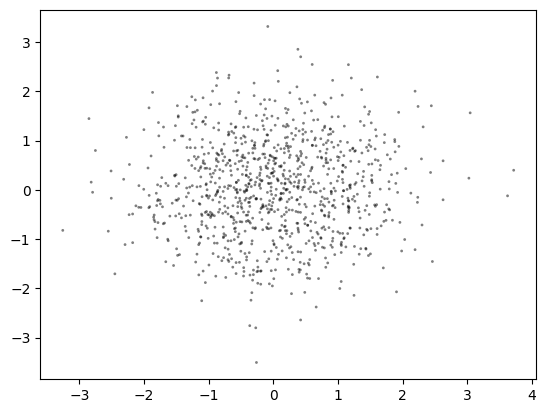

In [15]:
visualize_samples2(sample)

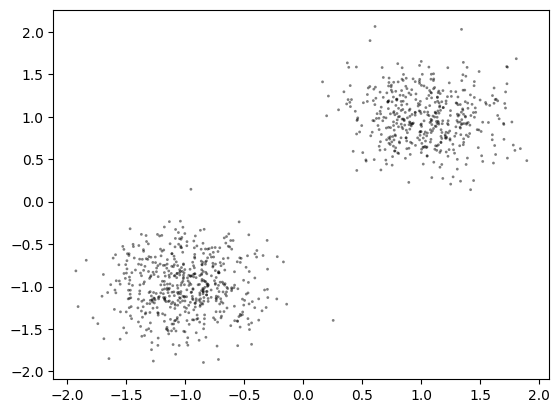

In [16]:
visualize_samples2(final)

It is still equally divided. The distribution is supposed to appear as follows:

In [17]:
true_prob = torch.rand(1000) < p1
true_prob = true_prob.float()

normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))


true_sample = torch.stack([normal1.sample() if p else normal2.sample() for p in true_prob])

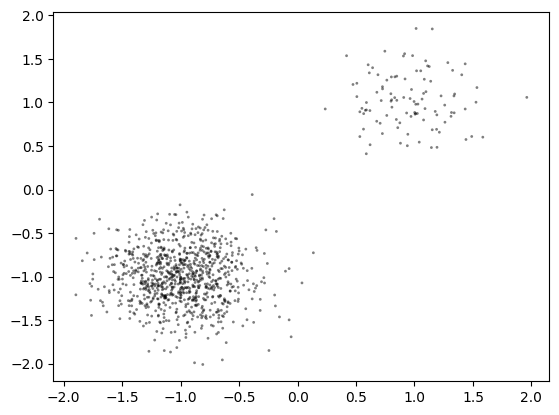

In [18]:
visualize_samples2(true_sample)

# Implementation 4: Noise Conditional Langevin Dynamics
Add decreasing noise to the data until convergence.

In [19]:
def annealed_langevin_dynamics(score, x, sigmas, num_steps=NUM_STEPS, step_size=LR):
    for sigma in sigmas:
        eps = (sigma / sigmas[-1]) ** 2 * step_size if sigma > 0 else step_size
        for _ in range(num_steps):
            score_x = score(x, sigma)
            x = x + 0.5 * eps * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
            x += np.sqrt(eps) * torch.randn_like(x)
        plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
        plt.title(f"sigma = {sigma}")
        plt.show()
    return x

In [20]:
def mixture_of_gaussians3(x, noise):
    normal1 = MultivariateNormal(mu1, (noise + sigma1) * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, (noise + sigma2) * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

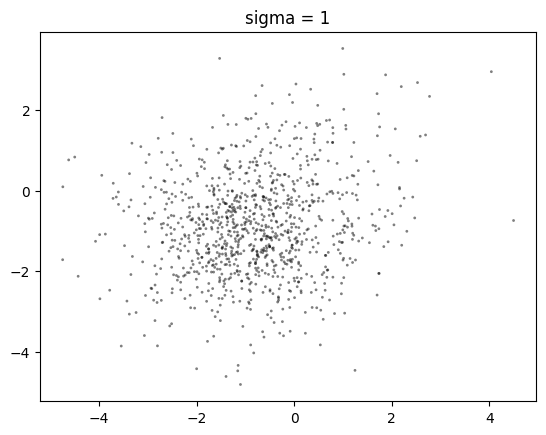

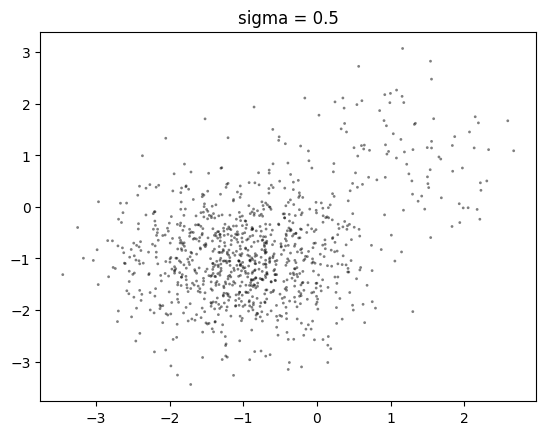

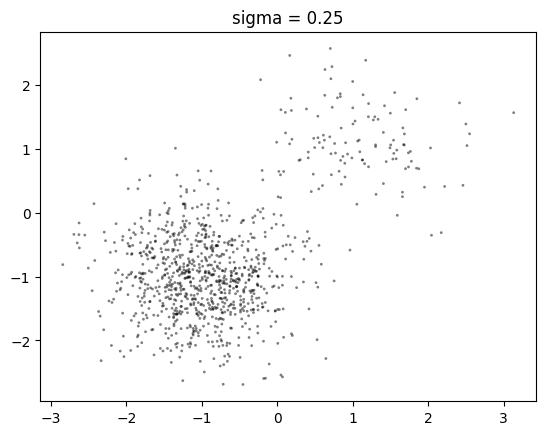

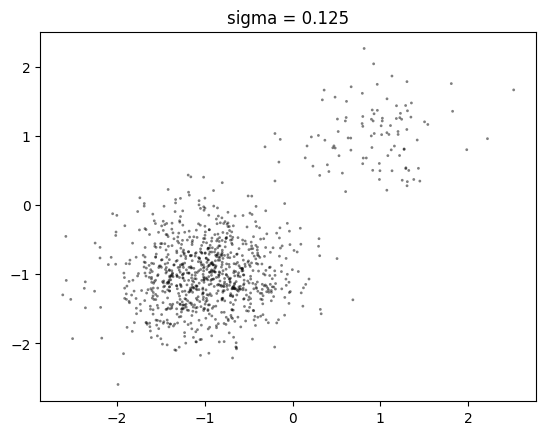

In [21]:
sample = torch.randn(1000, 2, requires_grad=True)
sigmas = [1, 0.5, 0.25, 0.125]
result = annealed_langevin_dynamics(mixture_of_gaussians3, sample, sigmas)

We can see that the annealed Langevin Dynamics do much better at estimating the distribution when it is not "even".

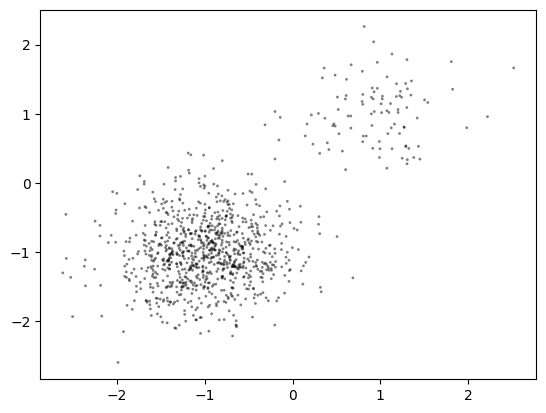

In [22]:
visualize_samples2(result)